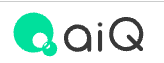

[disclaimer](./disclaimer.txt/)

# aiQ DataHub: aiQ POS ELEC Goods Sample Evaluation Notebook

- aiQ POS Elec Goods は家電量販店やネット通販での家電製品の売上データを TICKER ごとにまとめたデータです。

In [1]:
# 自作モジュールの更新を行うため、以下のコマンドを評価しておく
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io
import plotly.express as px
from aiq_strategy_robot.data.data_accessor import DAL
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_equity_prices,
    load_finnhub_dividends,
    load_finnhub_stock_splits,
    load_finnhub_equity_data,
    load_finnhub_symbol_lookup
)

In [3]:
for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')
from utils.shortcut.path import DEFAULT_DIR
from utils.shortcut import elec_dataset as sc

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [4]:
sdh = DAL()

## Step2: Load Data to `sdh`
ここではデータ分析のデモが主眼であるため、個別に用意しておいた簡易ローダーを経由してデータを読み込むこととする

In [5]:
sdh.extract.clear()

sc.load_sample_dataset(sdh)

display(sdh.extract_definition)

data_id_alt = 1
data_id_mkt = 2
data_id_funda = 3

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,External,Unknown,Unknown,aiq_pos_elec,"[1956-JP, 2180-JP, 2321-JP, 2323-JP, 2326-JP, ...","[TICKER, DATETIME]",2009-01-01 00:00:00,2024-06-30 00:00:00
2,RawData,External,Unknown,Unknown,market,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-07-03 00:00:00
3,RawData,external,sample,Unknown,sales,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2008-03-31 00:00:00,2024-01-31 00:00:00


### Step 2.1: 継続して日次でデータが取得できる銘柄を確認する
pos_sales が `datetime` 方向に少なくとも `lower_bound` の比率以上データが密に観測される銘柄を求める

In [6]:
variable = 'pos_sales'
lower_bound = 0.9
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2023-12-31')

In [7]:
# standard data handler に登録しておいた加工前データを取り出す
dfpos = sdh.get_raw_data(data_id_alt)

# index は DATETIME列のみの datetimeindex型にのみにする
dfcheck = dfpos[[variable]].unstack('TICKER').droplevel(0, axis=1)
if start_date:
    dfcheck = dfcheck.loc[dfcheck.index > start_date]
if end_date:
    dfcheck = dfcheck.loc[dfcheck.index < end_date]
dfcheck.dropna(how='all', axis=1, inplace=True)

# 全日付の総数を数える
num_obs = len(dfcheck)

# NaN ではない行の数を TICKER ごとに数える
dfcount = dfcheck.count()

# TICKER ごとに NaN ではない行の割合を求める
list_dense_tickers = dfcount.loc[dfcount / num_obs > lower_bound].index.tolist()

# 結果を print する
print(f'Tickers with observations for more than {lower_bound *  100}% of datetime after {start_date}.')
print(f'number of dense tickers: {len(list_dense_tickers)}')

Tickers with observations for more than 90.0% of datetime after 2020-01-01 00:00:00.
number of dense tickers: 70


### データが `sdh` に登録できたかを確認する

In [8]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_funda).tail())
display(sdh.get_raw_data(data_id_mkt).tail())

variable            pos_sales     share  unit_price  unit_price_vs_ind
TICKER  DATETIME                                                      
9928-JP 2022-11-05   0.003900  0.001311    0.130007           0.108800
        2023-10-26   0.003900  0.000422    0.130007           0.107093
        2023-12-22   0.016121  0.002433    0.537438           0.328411
        2024-01-31   0.016121  0.002665    0.537438           0.405101
        2024-02-12   0.016121  0.004272    0.537438           0.422939

sales
TICKER  DATETIME           
9997-JP 2022-12-31  61675.0
        2023-03-31  51922.0
        2023-06-30  51842.0
        2023-09-30  44263.0
        2023-12-31  60173.0

close
TICKER  DATETIME         
9997-JP 2024-06-27  772.0
        2024-06-28  768.0
        2024-07-01  791.0
        2024-07-02  791.0
        2024-07-03  789.0

## Step3: Correlation Analysis
aiQ POS Elec Goods のデータの性質から財務データ（四半期売上高）の間に相関関係があることが期待される。

その仮説が正しいのかここでは検証していきます。

#### オルタナティブデータの評価には `AltDataEvaluator` を使います。

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator
ade = AltDataEvaluator(sdh)

#### Step2 でロードしておいた四半期売上高データと POS Elec Goods の `pos_sales` を比較します
- 四半期売上データと `pos_sales` を比較可能とするために後者を resample します。

In [10]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variable_ids
alt_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variable_ids

- `pos_sales` と `unit_price` が財務と相関が高いことが分かるため、その積を新しい変数として作成します。

In [11]:
combo_feature = "sales*uprice"
alt_Q_ids += sdh.transform.multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name=combo_feature).resample(rule='Q', func='mean').variable_ids
features = list(sdh.get_raw_data(data_id_alt).columns) + [combo_feature]
features

['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind', 'sales*uprice']

In [12]:
# 描画してデータの形状を確認します。サンプルの TICKER を選びます。
sample_target = "7984-JP"

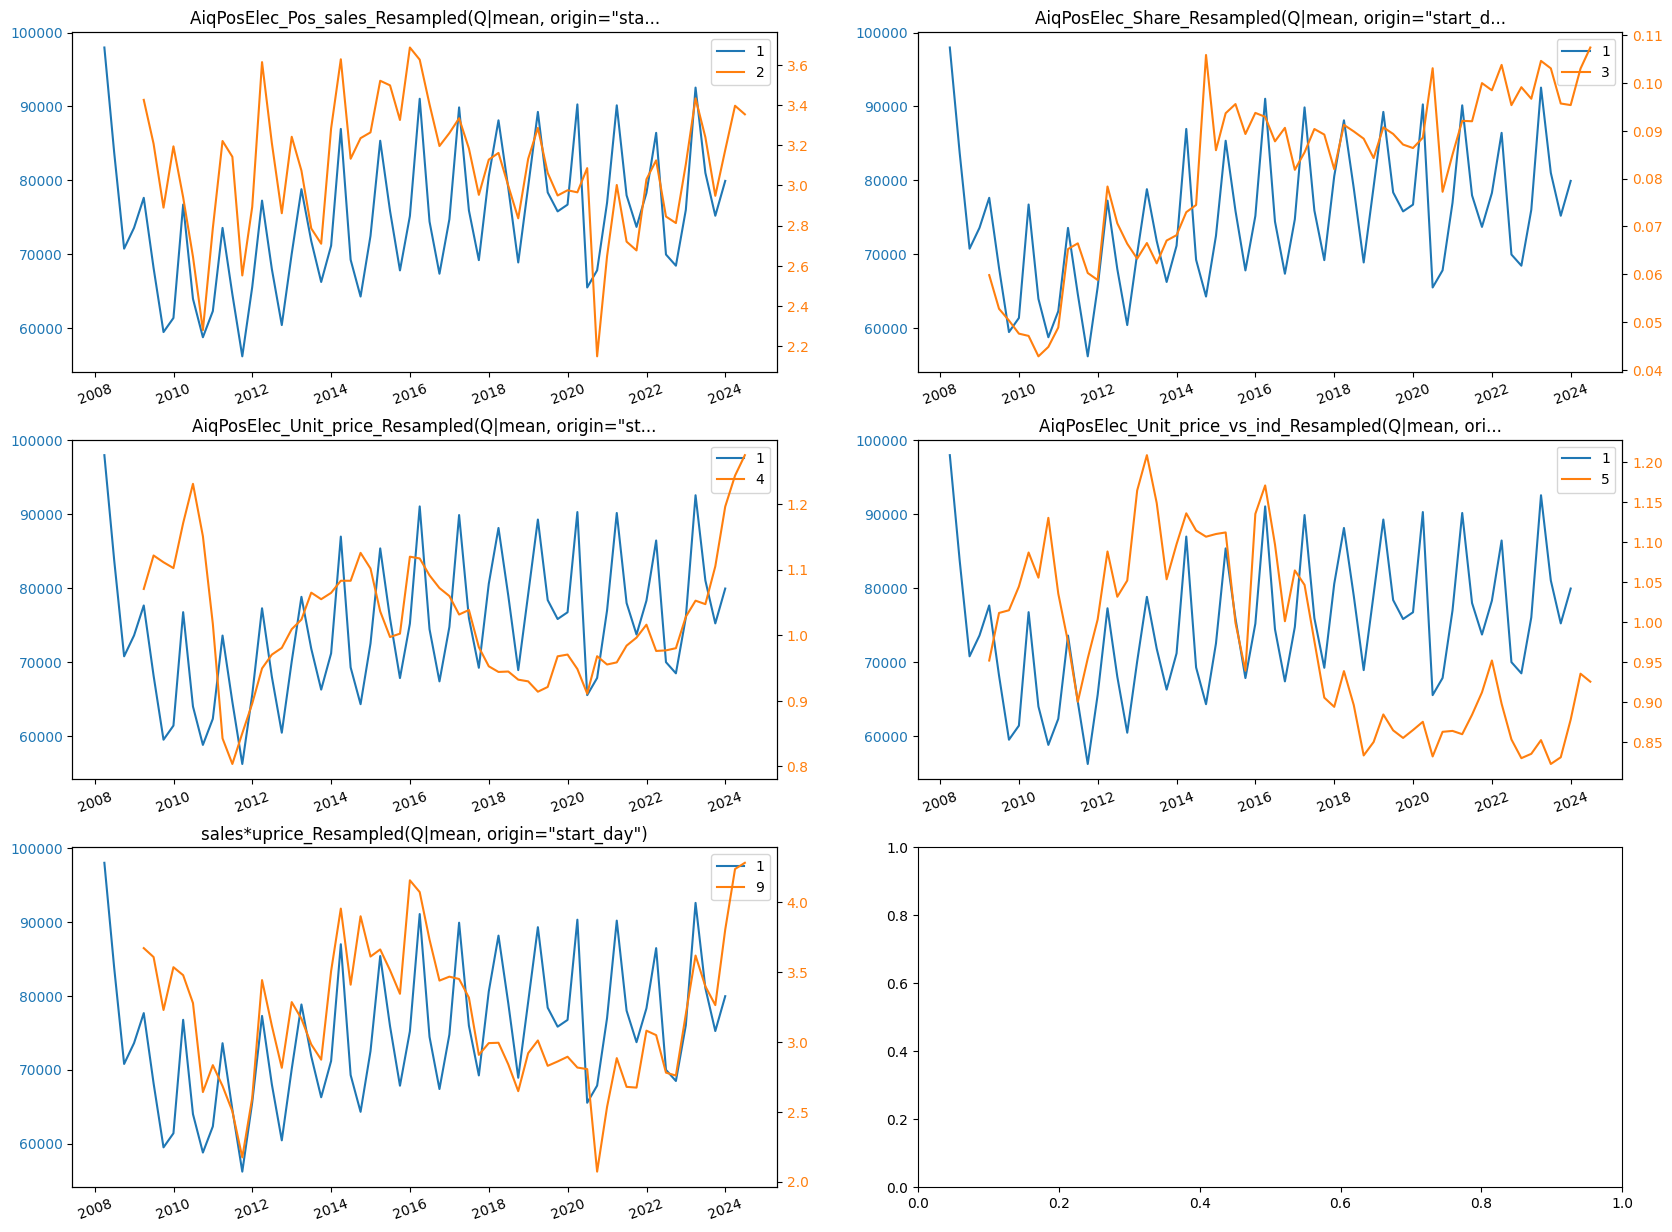

In [13]:
sdh.show_line_one_target(
    target=sample_target, #どの ticker のデータを描画するかを決めます
    y=funda_Q_ids[0], #y軸に表示するデータを variable_id で指定します
    X=alt_Q_ids, #x軸に表示するデータを variable_id の list で指定します（複数のグラフを一気に表示する時に list にします）
    col_num=2, #1行にいくつのグラフを表示するかを決めます
    vname_len_limit=50, #タイトルにXのvariable_id の変数名が表示されますが、表示を短くするために文字数を指定します
)

#### ベースとなる `variable` から変数を作成し、財務とマッチするのはどの変数か視覚的に確認できるようにします
- `sdh.transform` を使うことで様々な変数を作成し、どの変数が一番財務と関係性が強いのか一気に検証を行うことができます。
- `transform` の処理一覧は `data handler` のサンプル notebook を確認してください。

In [14]:
# まずは変数を定義します。
vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids\
    + sdh.transform.multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice").variable_ids
alt_Q_shift_03_ids = sdh.transform.shift(fields=vid_alt, periods=3).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_04_ids = sdh.transform.shift(fields=vid_alt, periods=4).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_05_ids = sdh.transform.shift(fields=vid_alt, periods=5).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_06_ids = sdh.transform.shift(fields=vid_alt, periods=6).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_07_ids = sdh.transform.shift(fields=vid_alt, periods=7).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_08_ids = sdh.transform.shift(fields=vid_alt, periods=8).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_09_ids = sdh.transform.shift(fields=vid_alt, periods=9).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_12_ids = sdh.transform.shift(fields=vid_alt, periods=12).resample(rule='Q', func='mean').variable_ids

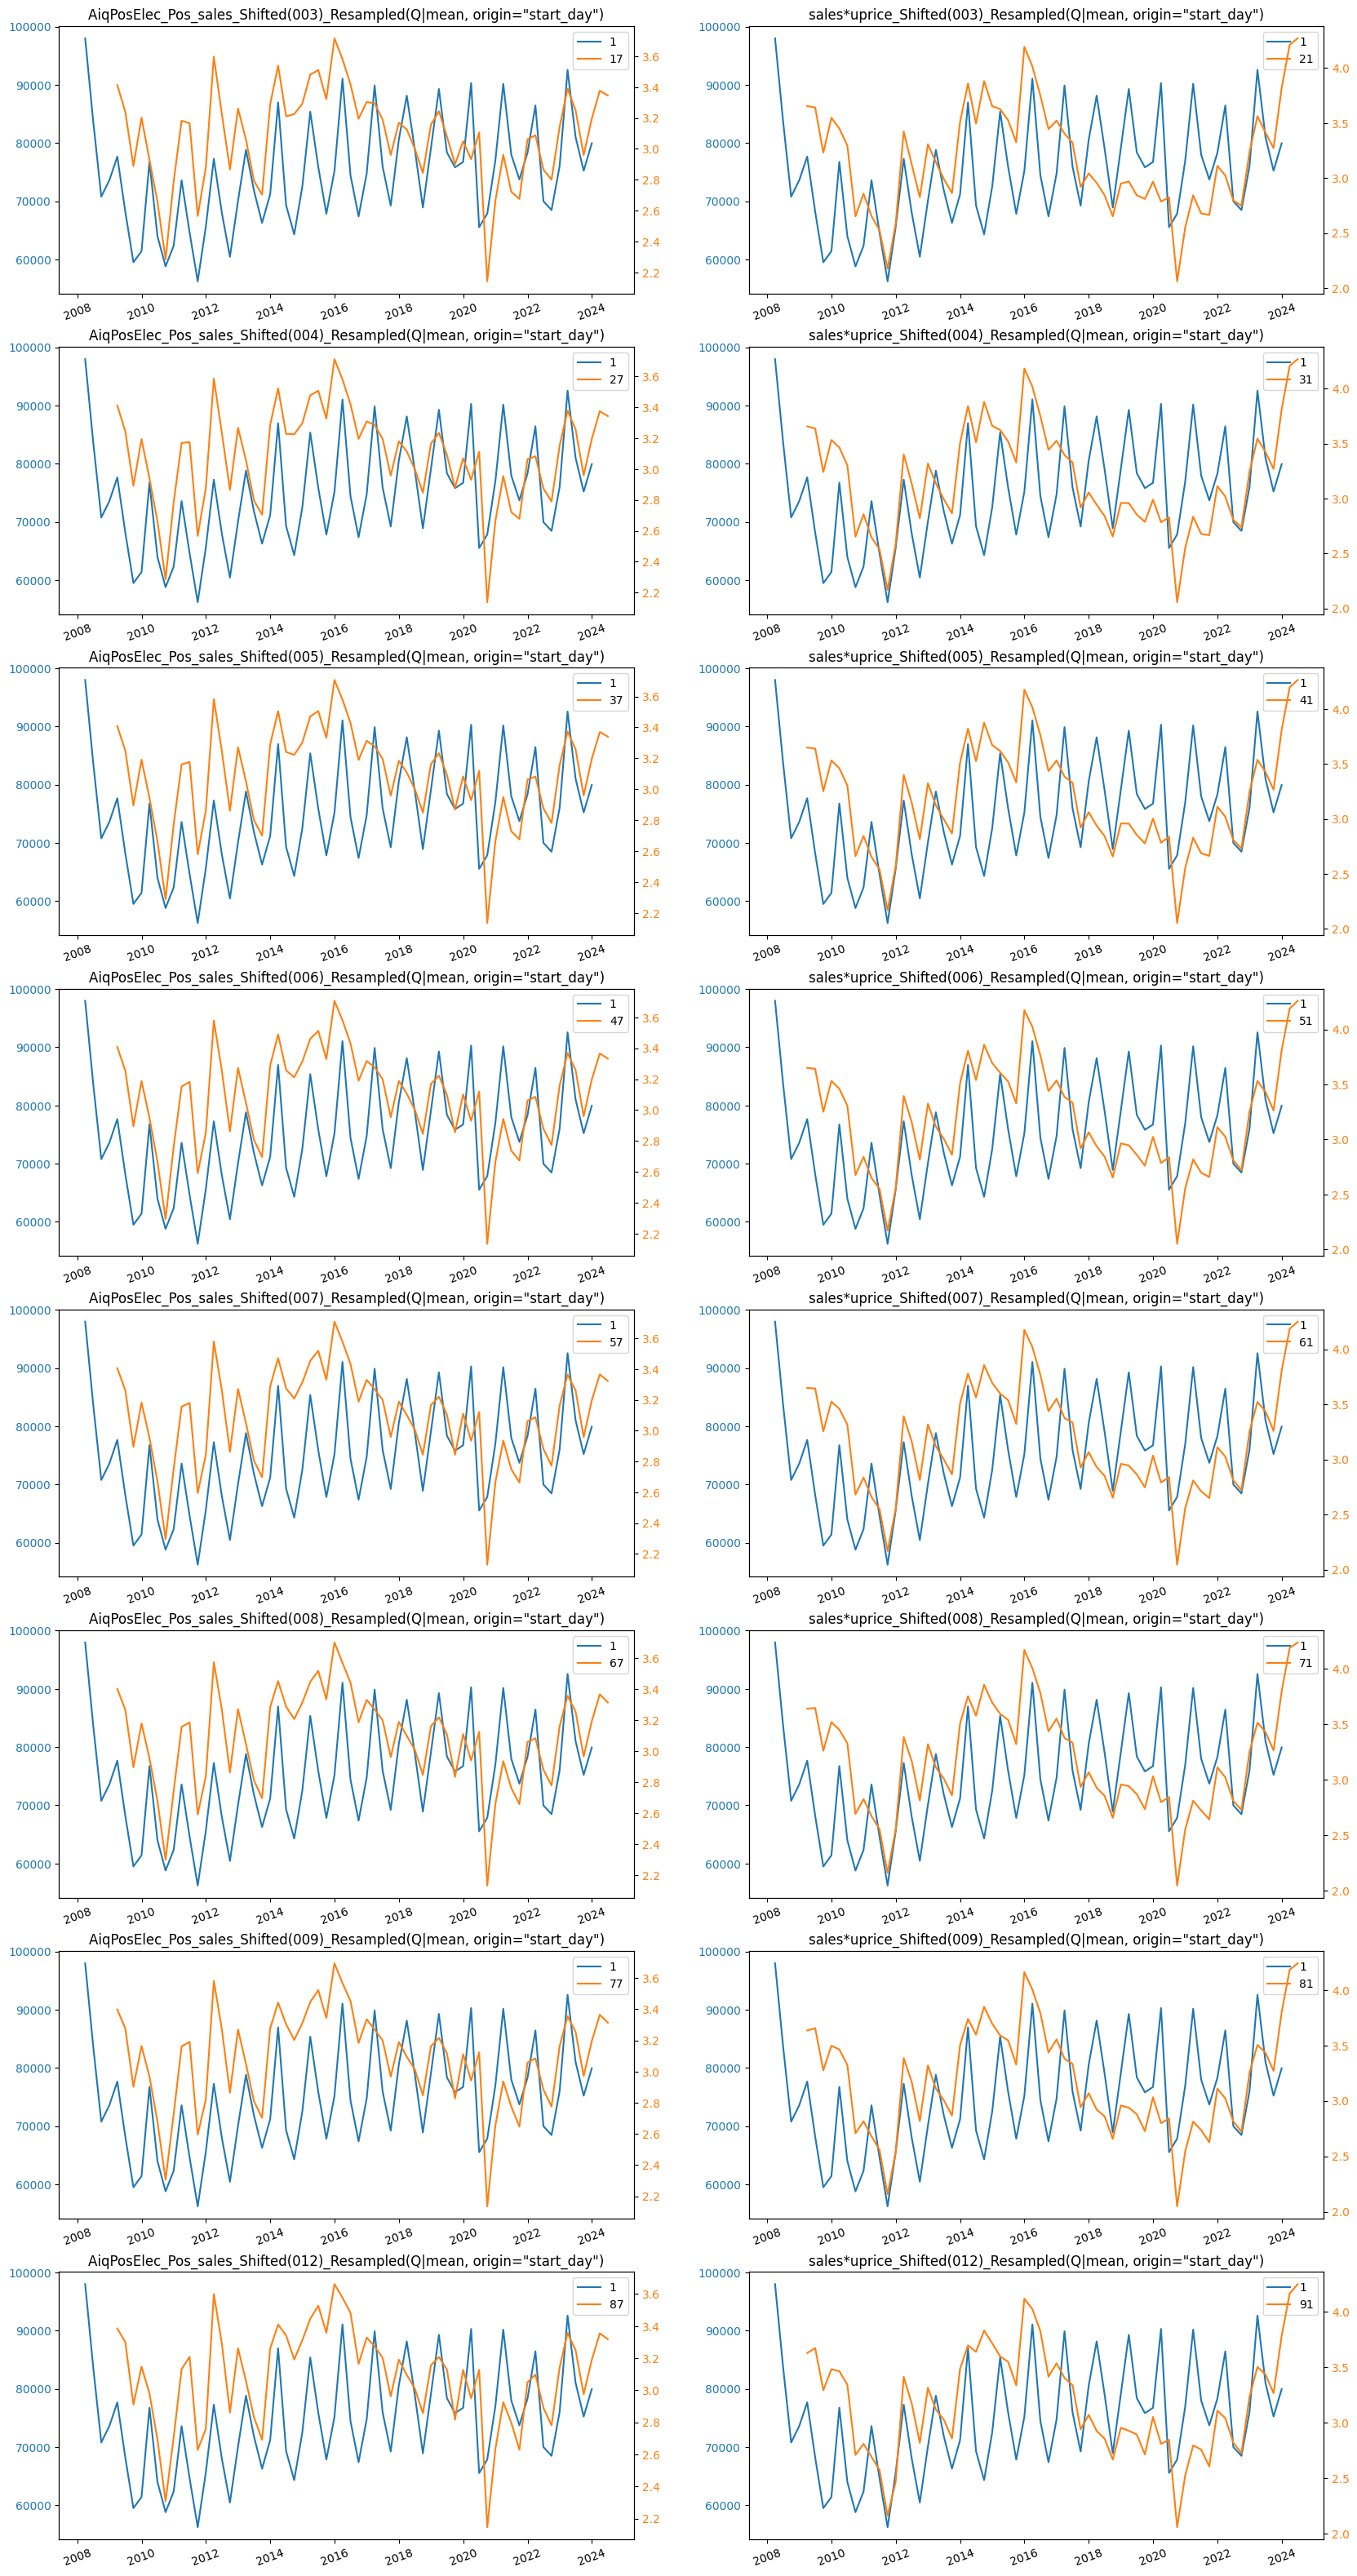

In [15]:
# 上記で作成した変数を描画して視覚的に確認します。
sdh.show_line_one_target(
    target=sample_target,
    y=funda_Q_ids[0],
    X=[alt_Q_shift_03_ids[0], alt_Q_shift_03_ids[4],
       alt_Q_shift_04_ids[0], alt_Q_shift_04_ids[4], 
       alt_Q_shift_05_ids[0], alt_Q_shift_05_ids[4],
       alt_Q_shift_06_ids[0], alt_Q_shift_06_ids[4], 
       alt_Q_shift_07_ids[0], alt_Q_shift_07_ids[4], 
       alt_Q_shift_08_ids[0], alt_Q_shift_08_ids[4], 
       alt_Q_shift_09_ids[0], alt_Q_shift_09_ids[4],
       alt_Q_shift_12_ids[0], alt_Q_shift_12_ids[4]],
    col_num=2
)

In [16]:
# 売上高とオルタナティブデータの相関係数を計算するのに、year over year に変換して相関を計算します。
sales_id                        = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).variable_ids[-1]
alt_Q_shift_00_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).variable_ids
alt_Q_shift_03_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).variable_ids
alt_Q_shift_04_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).variable_ids
alt_Q_shift_05_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).variable_ids
alt_Q_shift_06_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).variable_ids
alt_Q_shift_07_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).variable_ids
alt_Q_shift_08_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).variable_ids
alt_Q_shift_09_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).variable_ids
alt_Q_shift_12_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).variable_ids

# トレンドで相関が観測されてしまうケースもあるため、さらに一時差分をとった変数も作成します。
sales_diff_id                   = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
alt_Q_shift_00_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).diff(periods=1).variable_ids
alt_Q_shift_03_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_04_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_05_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_06_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_07_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_08_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_09_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_12_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).diff(periods=1).variable_ids

#### 相関計算

In [17]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=00'] = ade.compu_rho(alt_Q_shift_00_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=03'] = ade.compu_rho(alt_Q_shift_03_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=04'] = ade.compu_rho(alt_Q_shift_04_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=05'] = ade.compu_rho(alt_Q_shift_05_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=06'] = ade.compu_rho(alt_Q_shift_06_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=07'] = ade.compu_rho(alt_Q_shift_07_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=08'] = ade.compu_rho(alt_Q_shift_08_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=09'] = ade.compu_rho(alt_Q_shift_09_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=12'] = ade.compu_rho(alt_Q_shift_12_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=00_diff=1'] = ade.compu_rho(alt_Q_shift_00_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=03_diff=1'] = ade.compu_rho(alt_Q_shift_03_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=04_diff=1'] = ade.compu_rho(alt_Q_shift_04_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=05_diff=1'] = ade.compu_rho(alt_Q_shift_05_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=06_diff=1'] = ade.compu_rho(alt_Q_shift_06_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=07_diff=1'] = ade.compu_rho(alt_Q_shift_07_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=08_diff=1'] = ade.compu_rho(alt_Q_shift_08_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=09_diff=1'] = ade.compu_rho(alt_Q_shift_09_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=12_diff=1'] = ade.compu_rho(alt_Q_shift_12_logdiff_diff_ids, sales_diff_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=00,n_shift=03,n_shift=04,n_shift=05,n_shift=06,n_shift=07,n_shift=08,n_shift=09,n_shift=12,n_shift=00_diff=1,n_shift=03_diff=1,n_shift=04_diff=1,n_shift=05_diff=1,n_shift=06_diff=1,n_shift=07_diff=1,n_shift=08_diff=1,n_shift=09_diff=1,n_shift=12_diff=1
unit_price_vs_ind,3.839167,3.349990,3.260049,3.282684,3.280340,2.864297,2.796357,3.323035,2.714790,3.000716,2.038268,1.593824,2.278660,2.610879,1.667291,2.000176,1.636865,1.124872
sales*uprice,1.444614,0.698174,0.616668,0.467105,0.591208,0.397588,0.344572,0.433812,0.158764,3.715268,2.352215,1.734739,1.862165,2.004379,1.629151,2.590073,2.455960,2.075430
unit_price,1.375565,0.995346,0.852512,0.759927,0.937203,0.477410,0.615115,0.722213,0.351767,3.886931,3.103050,2.682422,2.862497,3.219754,2.804108,3.790802,3.800288,3.519875
pos_sales,0.440599,0.041447,0.050168,-0.062920,-0.083017,-0.222629,-0.261209,-0.449753,-0.698453,3.188171,2.359494,1.772336,1.706740,1.843718,1.507056,2.116412,1.584378,1.575766
share,-1.756082,-2.469809,-2.640193,-2.567632,-2.344864,-2.324460,-2.132178,-1.771783,-2.246416,0.270794,-0.210191,-0.984639,-1.455249,-1.073709,-1.207320,-0.753318,-0.870887,-0.972500


##### Ticker by Ticker で相関値を計算することもできます
- 以下では、上位5銘柄を選び出し関係性を描画します。

In [18]:
rho_time = ade.compu_rho(
    alt_Q_shift_06_logdiff_diff_ids,
    sales_diff_id, by='TICKER',
    rename_features=features,
    min_nsample=30
)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

An input array is constant; the correlation coefficient is not defined.


,pos_sales,share,unit_price,unit_price_vs_ind,sales*uprice
TICKER,,,,,
6955-JP,4.493644,4.315174,1.976216,1.851500,5.198503
7483-JP,2.308267,0.513930,-0.339687,-0.315979,1.048085
6702-JP,2.215386,1.673468,1.718957,1.409218,2.253864
6501-JP,1.974490,-3.286687,2.087341,1.011830,2.271959
6752-JP,1.838139,-0.012606,2.037801,0.137643,2.003162


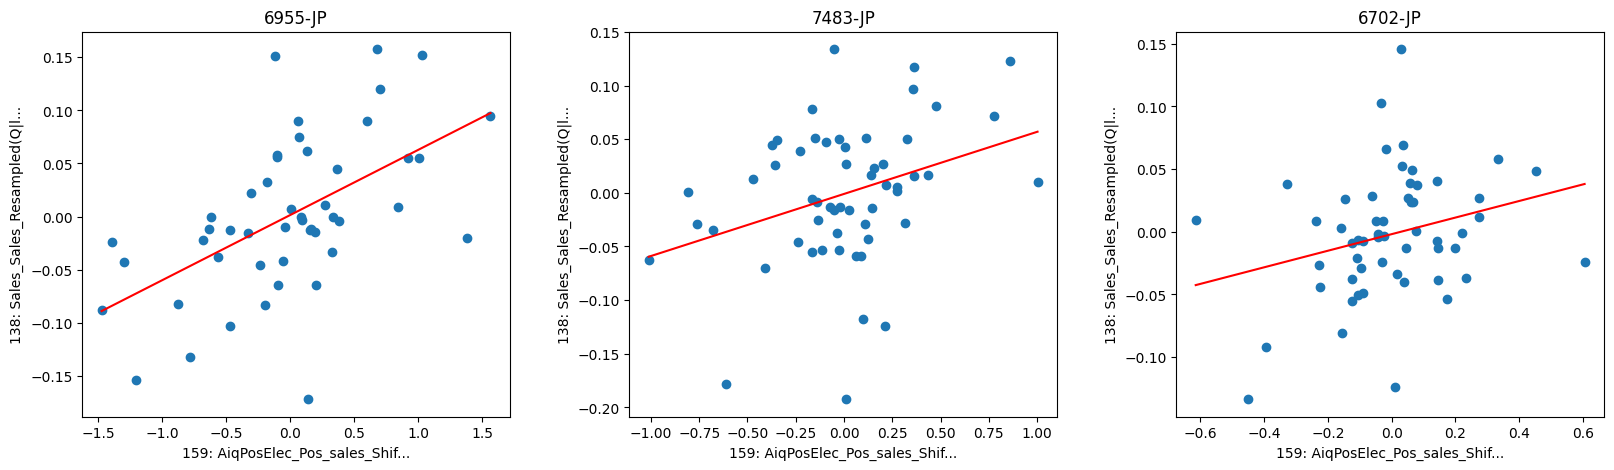

In [19]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_06_logdiff_diff_ids[0],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=25,
)

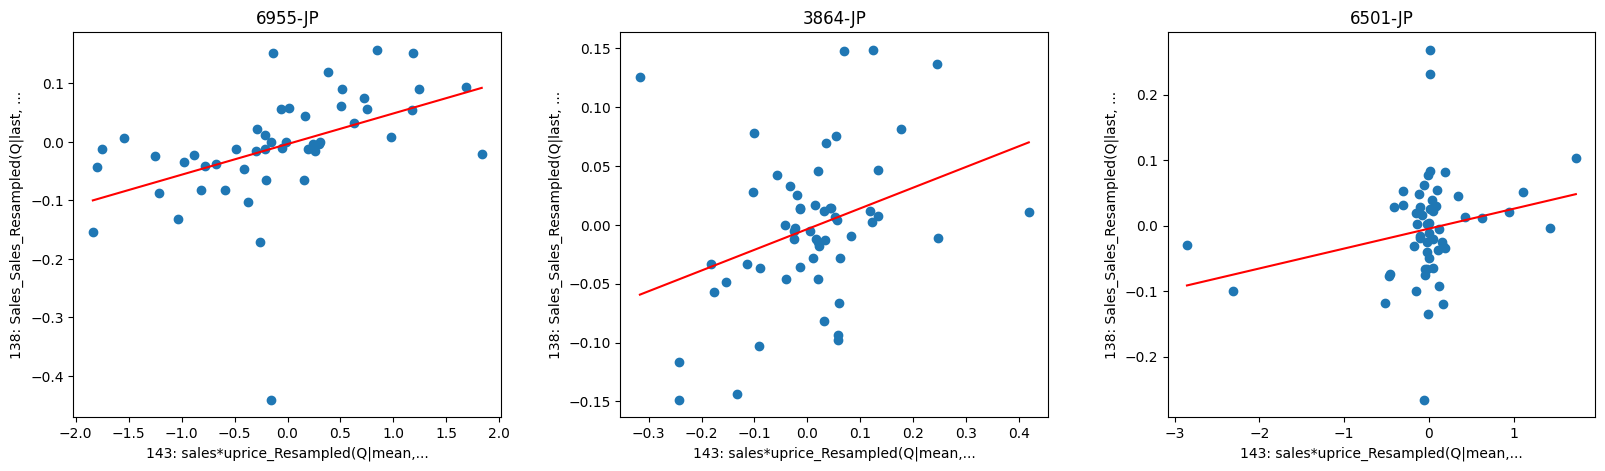

In [20]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('sales*uprice', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_00_logdiff_diff_ids[4],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=30,
)

### Step4: Quantile Backtest
- Step3で作成した変数をベースに、様々なファクターを作成して計算を行っていきます。
- ここでは2週移動平均をとった `sales*uprice` の変数をファクター値に選んでいます。
- 実務では移動平均値やシフト幅などのハイパーパラメータを変動させることで、バックテストの結果が大きく影響を受けないことを確認します。

In [21]:
close_ret = sdh.transform\
    .resample(data_id=data_id_mkt, rule='D', fields='close', func='last')\
    .dropna(how='all')\
    .log_diff(periods=1, names='ret')\
    .variable_ids[0]

In [22]:
sma_period = 14
min_period = int(max(np.floor(sma_period * 5 / 7), 1))
proto_trans_vid = sdh.transform\
        .multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice")\
        .resample(rule='D', func='last')\
        .sma(periods=sma_period, min_periods=min_period)\
        .reindex(label=close_ret)\
        .log_diff(periods=252)\
        .shift(periods=8)\
        .variable_ids[0]

In [23]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [24]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature=proto_trans_vid,
    actual_return=close_ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-0.050503,-0.003503,0.202465,-0.017299,0.528794,22.990667,-0.782143,-0.004478
#2,0.821450,0.056969,0.203669,0.279715,0.535603,39.019787,-0.574568,0.099151
#3,1.507694,0.104562,0.202178,0.517177,0.546950,23.822598,-0.486168,0.215073
#3-#1,1.558197,0.108064,0.117650,0.918521,0.537305,46.813264,-0.213449,0.506278
#3-#1(cost),1.220693,0.084658,0.117633,0.719677,0.530780,46.813264,-0.255725,0.331049
